In [3075]:
# Sources
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
# https://nbviewer.jupyter.org/github/OscarEngelbrektson/SyntheticControlMethods/blob/master/examples/user_guide.ipynb

In [3076]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import os 
from typing import List
from operator import add
from toolz import reduce, partial
from scipy import stats
from scipy.optimize import fmin_slsqp
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# read data file
# pandas read_csv
dirs = os.getcwd() 
files = os.listdir(dirs) 

data = pd.read_excel(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/MSc/data/processed raw data_2.xlsx') 
data = data.loc[ (data.year < 2021) & (data.year >= 1965)]
raw_data = copy.deepcopy(data)# Copy dataframe



In [3077]:
display(data)

,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Agriculture, forestry, and fishing, value added (% of GDP)",Exports of goods and services (% of GDP),...,Urban population growth (annual %),country,year
5,119.256800,11.106980,22.603944,...,6.729878,Algeria,1965
6,117.134400,11.106980,25.986198,...,5.894366,Algeria,1966
7,115.012000,11.106980,23.434417,...,3.266680,Algeria,1967
8,112.681400,11.106980,23.135635,...,3.307126,Algeria,1968
9,110.350800,11.106980,23.788777,...,3.292629,Algeria,1969
...,...,...,...,...,...,...,...
4570,9.410331,1.587936,46.684512,...,0.479309,European Union,2016
4571,9.143510,1.693777,48.354594,...,0.430422,European Union,2017
4572,8.927777,1.609880,49.198138,...,0.445310,European Union,2018
4573,8.739422,1.591050,49.344668,...,0.359546,European Union,2019


In [3078]:
print(data.columns)

Index(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
       'Population growth (annual %)', 'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)', 'country', 'year'],
      dtype='object')

In [3079]:
# make a list of countries 
lst_country =list(set(data.country))
print(sorted(lst_country))
print(len(lst_country))

['Algeria', 'Argentina', 'Australia', 'Bangladesh', 'Belize', 'Benin', 'Bolivia', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Congo, Rep.', 'Costa Rica', 'Cote dIvoire', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Eswatini', 'European Union', 'Fiji', 'Gabon', 'Gambia, The', 'Ghana', 'Guatemala', 'Guyana', 'Honduras', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Jamaica', 'Kenya', 'Korea, Rep.', 'Lesotho', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania', 'Mexico', 'Morocco', 'Nepal', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Senegal', 'Sierra Leone', 'Singapore', 'Sri Lanka', 'Sudan', 'Syrian Arab Republic', 'Thailand', 'Togo', 'Tunisia', 'Turkey', 'Uganda', 'Uruguay', 'Venezuela, RB', 'Zambia', 'Zimbabwe']
75


In [3080]:
tmp = ''
for c in sorted(lst_country):
    tmp += " "+c + ','
print(tmp)
print(len(lst_country))

 Algeria, Argentina, Australia, Bangladesh, Belize, Benin, Bolivia, Botswana, Brazil, Burkina Faso, Burundi, Cameroon, Chad, Chile, China, Colombia, Congo, Rep., Costa Rica, Cote dIvoire, Dominican Republic, Ecuador, Egypt, Arab Rep., El Salvador, Eswatini, European Union, Fiji, Gabon, Gambia, The, Ghana, Guatemala, Guyana, Honduras, India, Indonesia, Iran, Islamic Rep., Iraq, Jamaica, Kenya, Korea, Rep., Lesotho, Madagascar, Malaysia, Mali, Mauritania, Mexico, Morocco, Nepal, New Zealand, Nicaragua, Niger, Nigeria, Norway, Oman, Pakistan, Panama, Papua New Guinea, Paraguay, Peru, Philippines, Rwanda, Senegal, Sierra Leone, Singapore, Sri Lanka, Sudan, Syrian Arab Republic, Thailand, Togo, Tunisia, Turkey, Uganda, Uruguay, Venezuela, RB, Zambia, Zimbabwe,
75


## Descriptive statistics

enter variables

In [3081]:
incident = "QE"
incident_year = 2011
country = 'European Union'
variable = 'GDP growth (annual %)'

In [3082]:
def descriptive_statistics(raw_data, country, incident_year, end_year):
        # Divide data by the year incident_year to check descriptive statistics
        all = raw_data.loc[raw_data.country == country ].describe()
        before = raw_data.loc[raw_data.year <= incident_year ].loc[raw_data.country == country ].describe()
        after = raw_data.loc[raw_data.year >  incident_year ].loc[raw_data.year <= end_year ].loc[raw_data.country == country ].describe()

        # export to excel file
        all.to_excel('before_after.xlsx')
        before.to_excel('before.xlsx')
        after.to_excel('after.xlsx')

        # display data
        # display(all
        #         [['GDP (current US$)', 'GDP growth (annual %)',
        #        'Exports of goods and services (% of GDP)',
        #        'Imports of goods and services (% of GDP)',
        #        'Foreign direct investment, net inflows (BoP, current US$)',
        #        'Inflation, GDP deflator (annual %)']])

        display(before
                [['GDP (current US$)', 'GDP growth (annual %)',
            'Exports of goods and services (% of GDP)',
            'Imports of goods and services (% of GDP)',
            'Foreign direct investment, net inflows (BoP, current US$)',
            'Inflation, GDP deflator (annual %)']])
        display(after
                [['GDP (current US$)', 'GDP growth (annual %)',
            'Exports of goods and services (% of GDP)',
            'Imports of goods and services (% of GDP)',
            'Foreign direct investment, net inflows (BoP, current US$)',
            'Inflation, GDP deflator (annual %)']])

In [3083]:
descriptive_statistics(raw_data, country, incident_year, 2015)

,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,4.700000e+01,47.000000,47.000000,47.000000,4.700000e+01,47.000000
mean,5.853537e+12,2.500146,27.805037,27.646739,1.990654e+11,5.652892
std,4.641860e+12,1.682336,6.921298,6.079922,3.227478e+11,3.176397
min,7.259311e+11,-4.348065,19.364094,19.687489,2.899569e+09,0.929441
25%,1.887477e+12,1.870006,23.178097,24.222370,7.712106e+09,3.254789
50%,5.084288e+12,2.652813,25.840240,26.444708,3.614308e+10,4.563179
75%,8.026812e+12,3.634559,33.131713,31.539593,2.944256e+11,7.110288
max,1.629763e+13,6.009138,43.214743,41.531607,1.477512e+12,13.355808


,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,4.000000e+00,4.000000,4.000000,4.000000,4.000000e+00,4.000000
mean,1.478499e+13,0.786913,45.642035,42.006558,6.004422e+11,1.243586
std,9.236547e+11,1.395907,1.051721,0.531450,1.402052e+11,0.315529
min,1.355193e+13,-0.706732,44.803858,41.449658,4.307128e+11,0.982646
25%,1.436513e+13,-0.200678,44.924194,41.796124,5.487005e+11,1.022992
50%,1.496797e+13,0.771838,45.327268,41.923391,5.988103e+11,1.158214
75%,1.538782e+13,1.759428,46.045109,42.133825,6.505521e+11,1.378808
max,1.565210e+13,2.310708,47.109744,42.729792,7.734355e+11,1.675270


In [3084]:
descriptive_statistics(raw_data, country, incident_year, 2020)

,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,4.700000e+01,47.000000,47.000000,47.000000,4.700000e+01,47.000000
mean,5.853537e+12,2.500146,27.805037,27.646739,1.990654e+11,5.652892
std,4.641860e+12,1.682336,6.921298,6.079922,3.227478e+11,3.176397
min,7.259311e+11,-4.348065,19.364094,19.687489,2.899569e+09,0.929441
25%,1.887477e+12,1.870006,23.178097,24.222370,7.712106e+09,3.254789
50%,5.084288e+12,2.652813,25.840240,26.444708,3.614308e+10,4.563179
75%,8.026812e+12,3.634559,33.131713,31.539593,2.944256e+11,7.110288
max,1.629763e+13,6.009138,43.214743,41.531607,1.477512e+12,13.355808


,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,9.000000e+00,9.000000,9.000000,9.000000,9.000000e+00,9.000000
mean,1.497319e+13,0.655120,46.977625,43.167253,4.568700e+11,1.456795
std,8.317773e+11,2.725984,1.698431,1.581332,2.662967e+11,0.459473
min,1.355193e+13,-5.955778,44.803858,41.449658,-3.415352e+10,0.874115
25%,1.463620e+13,-0.031993,45.690230,41.935169,2.960592e+11,1.036441
50%,1.529193e+13,1.816850,46.684512,42.729792,5.400017e+11,1.464064
75%,1.565210e+13,2.065499,48.354594,44.077874,6.095910e+11,1.675270
max,1.597821e+13,2.813595,49.344668,45.897118,7.734355e+11,2.199604


In [3085]:
# Standardize independent variables
# mean 0 / variance 1

# features = [feature for feature in data.columns if feature not in ['country', 'year', variable]]
# print(features)
# data[features] = StandardScaler().fit_transform(data[features])


# 1. Raw data

In [3086]:
# data_gdp = data[
#     ['year','country','GDP growth (annual %)',
#     'Adolescent fertility rate (births per 1,000 women ages 15-19)',
#        'Agriculture, forestry, and fishing, value added (% of GDP)',
#        'Exports of goods and services (% of GDP)',
#        'Fertility rate, total (births per woman)',
#        'Foreign direct investment, net inflows (BoP, current US$)',
#        'Gross capital formation (% of GDP)',
#        'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'Life expectancy at birth, total (years)',
#        'Merchandise trade (% of GDP)',
#        'Mortality rate, under-5 (per 1,000 live births)',
#        'Population density (people per sq. km of land area)',
#         'Population, total',
#        'School enrollment, primary (% gross)', 'Surface area (sq. km)',
#        'Urban population growth (annual %)' ]]

# data_gdp_growth = data[
#     ['year','country','Adolescent fertility rate (births per 1,000 women ages 15-19)',
#        'Agriculture, forestry, and fishing, value added (% of GDP)',
#        'Exports of goods and services (% of GDP)',
#        'Fertility rate, total (births per woman)',
#        'Foreign direct investment, net inflows (BoP, current US$)',
#        'GDP (current US$)', 'GDP growth (annual %)',
#        'Gross capital formation (% of GDP)',
#        'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'Life expectancy at birth, total (years)',
#        'Merchandise trade (% of GDP)',
#        'Mortality rate, under-5 (per 1,000 live births)',
#        'Population density (people per sq. km of land area)',
#         'Population, total',
#        'School enrollment, primary (% gross)', 'Surface area (sq. km)',
#        'Urban population growth (annual %)' ]]

# data_inf = data[
#     ['year','country','Adolescent fertility rate (births per 1,000 women ages 15-19)',
#        'Agriculture, forestry, and fishing, value added (% of GDP)',
#        'Exports of goods and services (% of GDP)',
#        'Fertility rate, total (births per woman)',
#        'Foreign direct investment, net inflows (BoP, current US$)',
#        'GDP (current US$)', 'GDP growth (annual %)',
#        'Gross capital formation (% of GDP)',
#        'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'Life expectancy at birth, total (years)',
#        'Merchandise trade (% of GDP)',
#        'Mortality rate, under-5 (per 1,000 live births)',
#        'Population density (people per sq. km of land area)',
#         'Population, total',
#        'School enrollment, primary (% gross)', 'Surface area (sq. km)',
#        'Urban population growth (annual %)' ]]

# data_fdi = data[
#     ['year','country',    'Foreign direct investment, net inflows (BoP, current US$)',
#        'Adolescent fertility rate (births per 1,000 women ages 15-19)',
#        'Agriculture, forestry, and fishing, value added (% of GDP)',
#        'Exports of goods and services (% of GDP)',
#        'Fertility rate, total (births per woman)',
#        'GDP (current US$)', 'GDP growth (annual %)',
#        'Gross capital formation (% of GDP)',
#        'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'Life expectancy at birth, total (years)',
#        'Merchandise trade (% of GDP)',
#        'Mortality rate, under-5 (per 1,000 live births)',
#        'Population density (people per sq. km of land area)',
#         'Population, total',
#        'School enrollment, primary (% gross)', 'Surface area (sq. km)',
#        'Urban population growth (annual %)' ]]

# data_export = data[
#     ['year','country', 'Exports of goods and services (% of GDP)',
#     'Adolescent fertility rate (births per 1,000 women ages 15-19)',
#        'Agriculture, forestry, and fishing, value added (% of GDP)',
#        'Fertility rate, total (births per woman)',
#        'Foreign direct investment, net inflows (BoP, current US$)',
#        'GDP (current US$)', 'GDP growth (annual %)',
#        'Gross capital formation (% of GDP)',
#        'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'Life expectancy at birth, total (years)',
#        'Merchandise trade (% of GDP)',
#        'Mortality rate, under-5 (per 1,000 live births)',
#        'Population density (people per sq. km of land area)',
#         'Population, total',
#        'School enrollment, primary (% gross)', 'Surface area (sq. km)',
#        'Urban population growth (annual %)' ]]

# data_import = data[
#     ['year','country',       'Imports of goods and services (% of GDP)',
#     'Adolescent fertility rate (births per 1,000 women ages 15-19)',
#        'Agriculture, forestry, and fishing, value added (% of GDP)',
#        'Exports of goods and services (% of GDP)',
#        'Fertility rate, total (births per woman)',
#        'Foreign direct investment, net inflows (BoP, current US$)',
#        'GDP (current US$)', 'GDP growth (annual %)',
#        'Gross capital formation (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'Life expectancy at birth, total (years)',
#        'Merchandise trade (% of GDP)',
#        'Mortality rate, under-5 (per 1,000 live births)',
#        'Population density (people per sq. km of land area)',
#         'Population, total',
#        'School enrollment, primary (% gross)', 'Surface area (sq. km)',
#        'Urban population growth (annual %)' ]]

# data_lst = [data_gdp, data_gdp_growth, data_inf, data_fdi, data_export, data_import]

# for d in data_lst:
#     display(d)

In [3087]:
data_gdp = data[
    ['year','country','GDP (current US$)',
      'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'Gross capital formation (% of GDP)','GDP growth (annual %)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
        'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]

data_gdp_growth = data[
    ['year','country','GDP growth (annual %)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
        'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]

data_inf = data[
    ['year','country', 'Inflation, GDP deflator (annual %)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
        'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]


data_fdi = data[
    ['year','country', 'Foreign direct investment, net inflows (BoP, current US$)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Fertility rate, total (births per woman)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'Gross capital formation (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
       'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]



data_export = data[
    ['year','country', 'Exports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Inflation, GDP deflator (annual %)',
       'Surface area (sq. km)',
       'Merchandise trade (% of GDP)',
       'Life expectancy at birth, total (years)',
       'School enrollment, primary (% gross)']]

# data_import = data[
#     ['year','country', 'Imports of goods and services (% of GDP)',
#        'Industry (including construction), value added (% of GDP)',
#        'Inflation, GDP deflator (annual %)',
#        'School enrollment, primary (% gross)']]


data_import = data[
    ['year','country', 'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Inflation, GDP deflator (annual %)',
       'Surface area (sq. km)',
       'Merchandise trade (% of GDP)',
       'Life expectancy at birth, total (years)',
       'School enrollment, primary (% gross)']]

data_lst = [data_gdp, data_gdp_growth, data_inf, data_fdi, data_export, data_import]

# for d in data_lst:
#     display(d)

In [3088]:
def visulaize_origianl(country,interested_variable, data0):
  """
  Make graph with interested variable and country
  This function is to visulize the raw data 
  """

  # Make data0set that is only about entered country 
  str_expr = f"country == '{country}' " 
  data0_new = data0.query(str_expr) 

  # print(data0_new[interested_variable])
  plt.figure(figsize=(10,5)) 
  # plt.plot(data0['year'],data0[interested_variable],marker="o",alpha=.6, label = f'{interested_variable} with Non {country}',color='dimgray')
  plt.plot(data0_new['year'], data0_new[interested_variable])

  # plt.figure(figsize=(10,5)) 
  # plt.plot(data0['year'],data0[interested_variable],marker="o",alpha=.6, label = f'{interested_variable} with Non {country}',color='dimgray')
  # plt.plot(data0_new['year'],data0_new[interested_variable],label = f'{interested_variable} with {country}',color='black')   
  # # plt.vlines(x=incident_year,  ymin=-50, ymax=50, linestyle=":", lw=2, label=incident)
  # plt.gray()
  # plt.legend();  
  # plt.show()


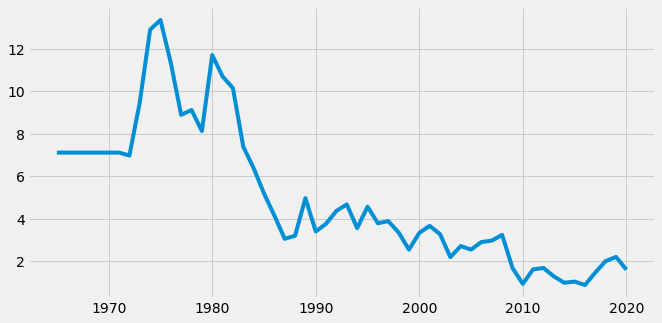

In [3089]:
visulaize_origianl('European Union','Inflation, GDP deflator (annual %)', data_inf )

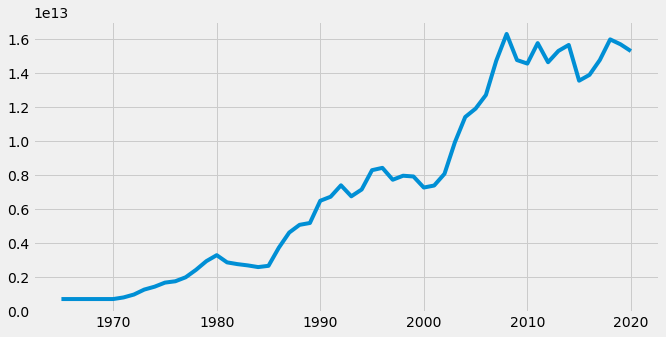

In [3090]:
visulaize_origianl(country ,'GDP (current US$)', data_gdp_growth)

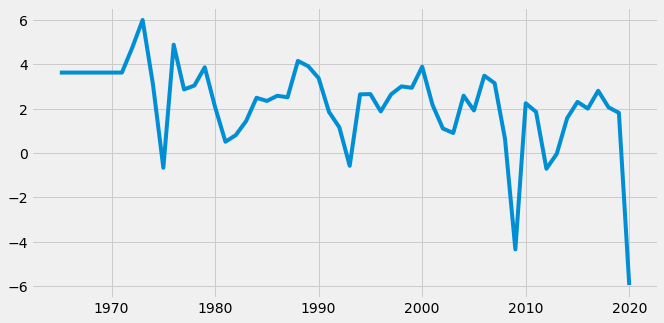

In [3091]:
visulaize_origianl(country ,'GDP growth (annual %)', data_gdp_growth)

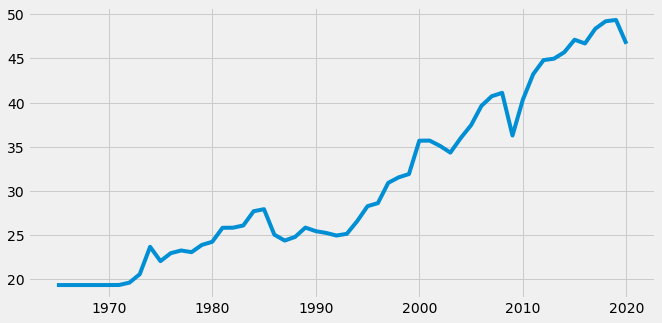

In [3092]:
visulaize_origianl('European Union','Exports of goods and services (% of GDP)', data_export )

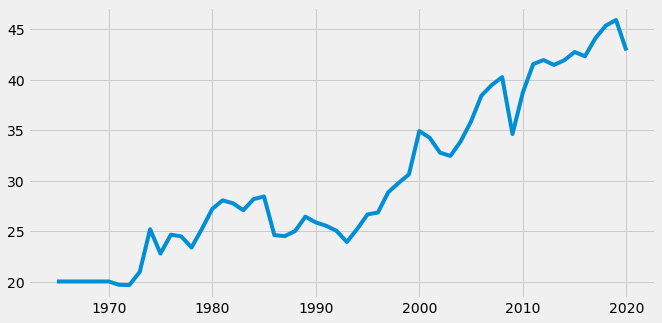

In [3093]:
visulaize_origianl('European Union','Imports of goods and services (% of GDP)', data_import )

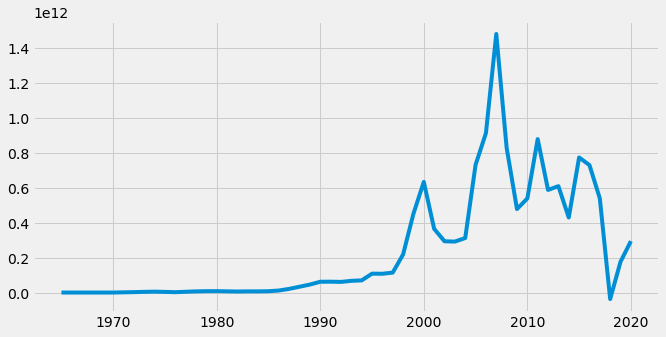

In [3094]:
visulaize_origianl('European Union','Foreign direct investment, net inflows (BoP, current US$)', data_fdi )

# 2. Synthetic Control Method

In [3095]:
def X_y(country, main_variable, data0):
  """
   Get X and y
  """

  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values

  return X,y

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

def sythetic_weight(country, interested_variable, data0):   
  """
  Get the weight of synthetic control.
  """

  data_weights = get_w(X_y(country, interested_variable, data0)[0], X_y(country, interested_variable, data0)[1])
  
  print("Sum of weight:", data_weights.sum())
  print(data_weights)


  return np.round(data_weights, 4)

def synthetic_control(country, main_variable, data0):
  """
  This function is to generate the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year )]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the synthetic controls of countries in the pool or a given dataset
  weights_synth = sythetic_weight(country, main_variable, data0)
  weights_synth.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_synth)

  data0_country['Synthetic'] = data_synth_lr

  return data0_country


def synthetic_control_dataframe(country, main_variable, data0):
 
  """
  This function is to make dataframe that contain the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  """

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2[f'Difference'] = data2[main_variable]- data2['Synthetic']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= incident_year]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > incident_year]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['Synthetic'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['Synthetic'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'Synthetic','Difference']]

def synthetic_plot(country,main_variable, data0):
  """
  Show the plot of synthetic control
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, main_variable, data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  # plt.vlines(x=incident_year, ymin=-200000, ymax=200000, linestyle=":", lw=2, label="QE")
  plt.ylabel(f"{main_variable} ")
  plt.legend();

def synthetic_plot_magnified(country, main_variable, data0):
  """
  Show the plot of synthetic control with samll values of main_variable
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, main_variable, data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  # plt.vlines(x=incident_year, ymin=-5000, ymax=5000, linestyle=":", lw=2, label="QE")
  plt.ylabel(f"{main_variable} ")
  plt.legend();


In [3096]:
# synthetic_plot(country ,'GDP growth (annual %)', data_gdp_growth)

## 3. Agumented Synthetic Control Method

In [3097]:

def agumented_synthetic_control(country, main_variable, data0):
  """
  This function is to make dataframe that contain the value of ASCM

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  data0_country['ASCM'] = data_synth_lr

  return data0_country

def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def agumented_synthetic_control_dataframe(country, main_variable, data0):

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = agumented_synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2['Difference'] = data2[main_variable]- data2['ASCM']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= incident_year ]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > incident_year ]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['ASCM'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['ASCM'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'ASCM','Difference']]


# Country : The country you want to see
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_weight_visualize(country, main_variable, data0):
  """
  This function is for showing the weight of countries from ridge ASMC

  # Country : The country you want to see
  # main_variable: Variable you want to see. ex) CA
  # data0 : data that you have
  
  """

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge_rounded = weights_ridge.round(3)

  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  dic = {}
  for index in range(len(pool)-1):
    dic[pool[index]] = weights_ridge_rounded[index]
  return dic

# Country : The country you want to see
# pool: list of country in data set
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_synthetic_control_visualize(country, main_variable, data0, scale=True):

  if scale:
    features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
    data0[features] = StandardScaler().fit_transform(data0[features])
  
  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]
  
  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)
  # print(weights_ridge)
  print(data_synth_lr)


  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray', linestyle=":", lw=1)
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black', lw=1)
  # max = data0.query(f"country == '{country}'")[main_variable].max()
  # min = data0.query(f"country == '{country}'")[main_variable].min()

  max = data_synth_lr.max()
  min = data_synth_lr.min()
  plt.grid(False)

  plt.vlines(x=incident_year , ymin= min, ymax=max , linestyle=":", lw=2, label="QE")
  plt.ylabel(f"{main_variable}")
  plt.legend();



In [3098]:
# synthetic_plot(country ,'GDP (current US$)', data_gdp)

[1.01025995e+12 9.82742308e+11 1.04944629e+12 1.25681724e+12
 1.28227629e+12 9.17777029e+11 9.40597242e+11 1.25762183e+12
 2.21867533e+12 2.28262470e+12 2.60496721e+12 2.47023694e+12
 2.72161149e+12 4.47861717e+12 5.73136946e+12 3.94621836e+12
 3.19764872e+12 1.68165549e+12 2.54326014e+12 2.62651549e+12
 6.28079287e+12 7.27093800e+12 6.93973039e+12 7.74762510e+12
 7.18531637e+12 5.85466622e+12 6.52097321e+12 7.39953855e+12
 8.97491688e+12 2.84574142e+12 2.82379130e+12 5.33804760e+12
 6.51217205e+12 1.36154099e+13 1.45454548e+13 1.24355515e+13
 1.07130850e+13 1.27589691e+13 1.61629324e+13 1.92180158e+13
 1.89078513e+13 1.84971776e+13 2.19838545e+13 1.62724563e+13
 1.58493439e+13 1.34711781e+13 1.81750350e+13 2.32209868e+13
 2.16187852e+13 2.15597854e+13 2.51217396e+13 2.89875769e+13
 2.82783713e+13 2.52159603e+13 3.40586663e+13 4.04381324e+13]


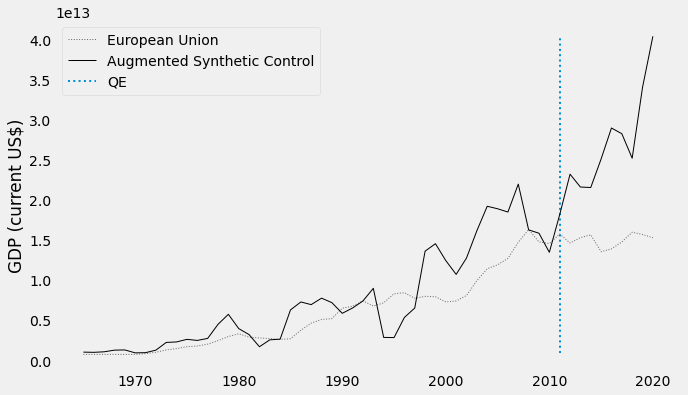

In [3099]:
agumented_synthetic_control_visualize(country ,'GDP (current US$)', data_gdp, False)

In [3100]:
# agumented_synthetic_control_visualize(country ,'GDP growth (annual %)', data_gdp_growth, False)

In [3101]:
# synthetic_plot(country ,'GDP growth (annual %)', data_gdp_growth)

[ 1.48422474e+08  1.48422474e+08  1.48422474e+08  1.48422474e+08
  1.48422474e+08  1.48422474e+08 -1.37014217e+08  5.78401256e+08
  1.22236508e+09  2.40796938e+08  8.18243499e+08  1.60845710e+09
  9.60832580e+08  7.90225963e+08  3.27985634e+09  2.97950136e+09
  6.96574920e+09  3.45374165e+09  4.15229206e+09  5.03363498e+09
  5.57278687e+09  6.53996760e+09  6.58814158e+09  6.28779718e+09
  8.71543442e+09  4.42434251e+09  1.48626611e+10  1.65168957e+10
  3.53108576e+10  6.36267695e+10  5.29138384e+10  6.59252075e+10
  7.86527348e+10  8.94539506e+10  9.90458314e+10  1.07295115e+11
  1.31284342e+11  1.13937821e+11  1.08470987e+11  1.21782580e+11
  2.32989584e+11  1.71839954e+11  2.29418258e+11  2.20983177e+11
  1.54853071e+11  3.10415974e+11  2.90892141e+11  2.64176490e+11
  3.80663677e+11  2.83143909e+11  2.74065409e+11  2.06663286e+11
  2.11101894e+11  2.60624641e+11  2.12244907e+11  2.33096226e+11]


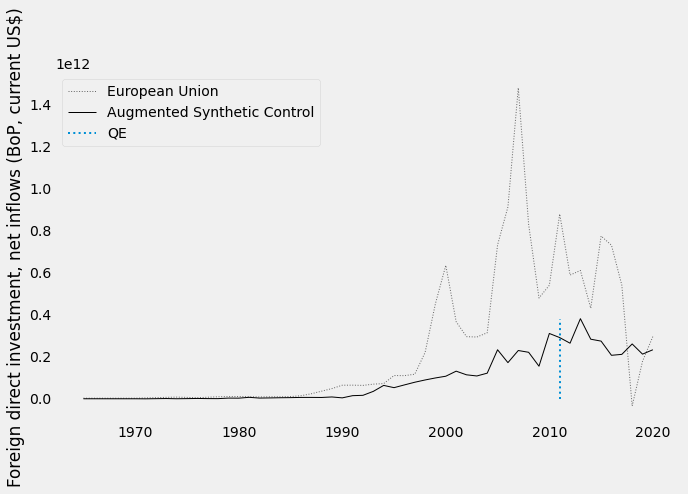

In [3102]:
agumented_synthetic_control_visualize(country ,'Foreign direct investment, net inflows (BoP, current US$)', data_fdi, True)

[21.47150088 20.35172282 19.6197937  20.12070048 19.51204366 20.89862752
 19.80321886 18.21601459 18.87772801 24.32021301 24.29678254 23.44666518
 23.35366435 22.2051325  25.1363988  23.39937266 24.33335064 23.70881506
 22.81083014 25.17990164 24.08074855 24.93981797 23.5908802  24.67096738
 26.10695797 27.23375536 19.68911647 23.70808151 25.08493929 27.32338306
 28.7914636  30.55392397 32.58972419 30.64508086 33.20184116 37.89079975
 37.33301913 36.99704503 36.26454074 38.34323682 38.76619676 41.98804657
 40.88254749 44.77180995 38.53903916 40.71476244 44.18723626 44.13033112
 41.27518681 39.85598882 37.74806333 35.63781185 36.5844246  37.66267502
 40.06018952 37.30187314]


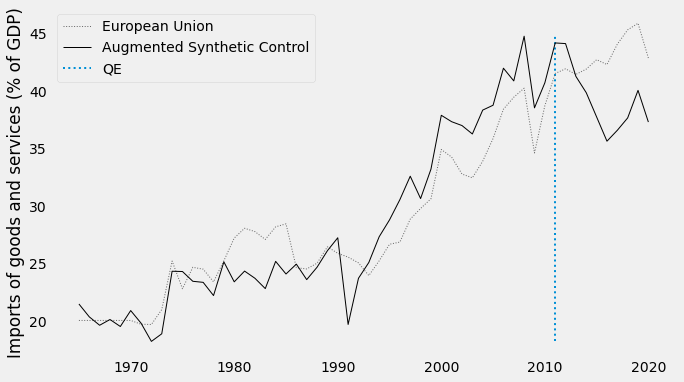

In [3103]:
agumented_synthetic_control_visualize(country ,'Imports of goods and services (% of GDP)', data_import, True)

[17.45157938 17.9582549  16.84368421 17.48076502 17.28950877 18.07659354
 16.39305545 17.06394592 18.7388899  17.4906419  18.08617902 19.71297074
 18.48123392 19.44151064 19.90266937 19.11445008 20.03128737 20.86072985
 22.08707482 24.78683937 23.65193214 26.25424941 24.81054522 27.00953377
 24.3249696  24.72818859 23.28387283 23.5925139  24.56005335 25.62374969
 27.2152896  28.7352285  29.84714972 32.90024591 31.06756982 33.5315076
 34.86462114 33.34960653 33.25898508 34.6309562  35.53639834 39.94425542
 40.07592132 41.22031504 39.40045173 39.38234371 41.61602841 41.80818807
 40.0731826  40.70092773 38.222884   36.44723703 37.45274    37.33348336
 39.55600021 36.56553382]


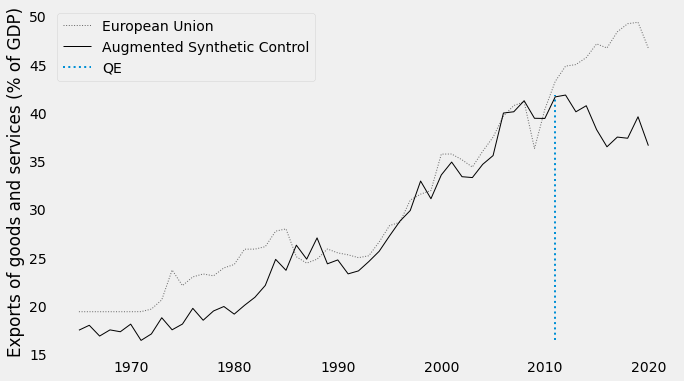

In [3104]:
agumented_synthetic_control_visualize('European Union','Exports of goods and services (% of GDP)', data_export,True )

In [3105]:
# synthetic_plot(country ,'Inflation, GDP deflator (annual %)', data_inf)

In [3106]:
# agumented_synthetic_control_visualize(country ,'Inflation, GDP deflator (annual %)', data_inf)

In [3107]:
# agumented_synthetic_control_visualize(country ,'GDP growth (annual %)', data_gdp_growth)

In [3108]:
# agumented_synthetic_control_visualize(country ,'Inflation, GDP deflator (annual %)', data_inf)

In [3109]:
# visulaize_origianl(country ,'Inflation, GDP deflator (annual %)', data_inf)

In [3110]:
# agumented_synthetic_control_visualize(country ,'Foreign direct investment, net inflows (BoP, current US$)',data_fdi )

In [3111]:
vfadsf

NameError: name 'vfadsf' is not defined

## 4. Robust analysis

In [ ]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def rmspe_table(main_variable, data0):
  print('*'*300)
  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)
  
  # Make list that contain names of countries
  pool = list(data1['country'].unique())
  
  # find the first country of this dataset 
  first_country = list(data0['country'])[0]

  # check the number of data for first country
  first_country_data_number = data0.loc[data0['country'] == first_country].shape[0]

  for each_country in pool:

    str_expr = f"country == '{each_country}' " 
    data0_new = data0.query(str_expr) 

    # here we will check whether the number of data for other countries would be the same
    # not all countries have the smae number of yearly data
    if first_country_data_number == data0_new.shape[0]:

      # Make dataframe that contain values of augmented synthetic control
      data2 = agumented_synthetic_control(each_country, main_variable, data1)

      # Add column of difference
      data2['Difference'] = data2[main_variable]- data2['ASCM']

      # Make dataframe that contain pre-treatment period only
      data_pre = data2.loc[data2.year <= incident_year ]

      # Make dataframe that contain post-treatment period only
      data_post = data2.loc[data2.year > incident_year ]

      print('*'*300)
      print('<',each_country,'>')
      print('')

      # Calculate RMSPE for pre-treatment period only
      rmspe_pre = rmse(data_pre[main_variable], data_pre['ASCM'])
      print(f'Pre- RMSPE :', rmspe_pre )
      print('')
      # Calculate RMSPE for post-treatment period only
      rmspe_post = rmse(data_post[main_variable], data_post['ASCM'])
      print(f'Post- RMSPE :', rmspe_post )
      print('')
      print('Ratio Post_RMSPE/Pre_RMSPE : ',rmspe_post/rmspe_pre )
      print('')
      print('*'*300)


def placebo_visualize(interested_country, interested_variable, input_data):
  # Make dataframe that contains
  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  # find the first country of this dataset 
  first_country = list(input_data['country'])[0]

  # check the number of data for first country
  first_country_data_number = input_data.loc[input_data['country'] == first_country].shape[0]

  synth_list = []
  for country in pool:
    str_expr = f"country == '{country}' " 
    data0_new = input_data.query(str_expr) 
    
    if first_country_data_number == data0_new.shape[0]:
      # Make temporary dataframe that contains synthetic values
      temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
      synth_list.append(temp_dataframe)
  
  # Make gahtered data
  data_synth_all= pd.concat(synth_list, axis = 0, sort= False)

  # Make a plot for all country except interested_country
  plt.figure(figsize=(10,6))
  plt.plot(data_synth_all['year'],data_synth_all[f'{interested_variable}']-data_synth_all['ASCM'],marker="o",alpha=.6, label = 'placebo effect',color='dimgray') 
  
  # Make a plot for interested country
  temp_dataframe2 = agumented_synthetic_control(interested_country, interested_variable, input_data)

  plt.plot(temp_dataframe2['year'],temp_dataframe2[f'{interested_variable}']-temp_dataframe2['ASCM'], alpha=.6, label = f'QE impact on {interested_country}',color='black')
  # plt.vlines(x=incident_year , ymin=-100000, ymax=200000, linestyle=":", lw=2, label="QE")
  plt.ylabel("")
  plt.legend();  
  plt.show()

def p_value_analysis(interested_country, interested_variable, input_data):
  """
  Note
  Treatment effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the interested country)
  Placebo effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the all the other country except the main country)

  P-value is calculated with following two steps 
  - 1st step : Count the number of placebo effects that have larger absolute values than those of treatment effects.
  - 2nd step : Divide the value from 1st step by the total number of countries 
  """

  # Make list that contains sum of absolute placebo effect value
  placebo_all_year = []

  # Make list that contains sum of absolute treatment effect value
  treatment_all_year = []

  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  # Make list of year in a dataframe
  pool_year = list(input_data['year'].unique())
  current_year = 2008
  
  # find the first country of this dataset 
  first_country = list(input_data['country'])[0]

  # check the number of data for first country
  first_country_data_number = input_data.loc[input_data['country'] == first_country].shape[0]

  for year in range(-13,0):# year is -13,-12,-11 ... This is to select ASCM from 2008 to 2021
    synth_list = []
    current_year += 1

    for country in pool:
      str_expr = f"country == '{country}' " 
      data0_new = input_data.query(str_expr) 

      if first_country_data_number == data0_new.shape[0]:      
        # Make temporary dataframe that contains synthetic values
        temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
        
        # print(temp_dataframe)
        value_agumented_synthetic_control  = temp_dataframe.iloc[year,-1] # (left: row), (right:column)
        value_interested_variable  = temp_dataframe.iloc[year,2]

        # print(value_interested_variable, value_synthetic_control)
        placebo_effect = value_interested_variable - value_agumented_synthetic_control
        synth_list.append(placebo_effect)

    # Calculate synthetic value for interested country in 2020 year
    synth_interested_country = agumented_synthetic_control(interested_country, interested_variable, input_data)

    value_agumented_synthetic_control_main_country = synth_interested_country.iloc[year,-1]
    value_interested_variable_main_country = synth_interested_country.iloc[year,2]

    treatment_effect = value_interested_variable_main_country - value_agumented_synthetic_control_main_country

    treatment_all_year.append(abs(treatment_effect))
    # Make dictionray to summarise placebo effect
    
    placebo_effect_dictionary = {}
    for now_country, placebo_value in zip(pool[0:-1],synth_list[0:-1]):
      placebo_effect_dictionary[now_country] = placebo_value
    print('Placebo effects:',placebo_effect_dictionary )

    # Make a new list that contains placebo effects which are larger than the treatment effect
    sorted_list= [placebo_effect for placebo_effect in synth_list if abs(placebo_effect) > abs(treatment_effect)]

    p_value = len(sorted_list)/(len(synth_list)-1) # -1: exclude the interested country in the list

    # Print treament effect
    print(f'QE Treatment Effect for the Year {current_year} ({interested_country}): {treatment_effect}')
    print(f'p-value : {p_value}')
    print('')
    print('')


def agumented_synthetic_control_visualize_limit_donor_pool(country, main_variable, data0):
    # print(list(data0['country'].unique())[-1:])
    country_list  = list(data0['country'].unique())
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'QE'
        print('')
        print('Countries:', country_list[0:-1])
        data0['QE'] = [1 if t else 0 for t in list(data0['year'] > 2008.0)]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
        inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)

        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count}",color='black')
        # plt.vlines(x=incident_year ,  ymin=-200000, ymax=200000, linestyle=":", lw=2, label="QE")
        plt.ylabel(f"{main_variable}")
        plt.legend();
        country_list.pop(0)
        count += 1


def agumented_synthetic_control_visualize_limit_donor_pool_magnified(country, main_variable, data0):
    """
    Visualize variable with small values
    """

    country_list  = list(data0['country'].unique())
    
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'QE'
        print('')
        print('Countries:', country_list[0:-1])
        data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year )]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
        inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)

        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count}",color='black')
        # plt.vlines(x=incident_year ,  ymin=-10000, ymax=10000, linestyle=":", lw=2, label="QE")
        plt.ylabel(f"{main_variable}")
        plt.legend();
        country_list.pop(0)
        count += 1




In [ ]:
# country_list  = list(data['country'].unique())
# print(len(country_list))
# country_list.remove('European Union')
# print(len(country_list))
# country_list.append('European Union')
# print(len(country_list))

In [ ]:
# asdfasd

In [ ]:
rmspe_table(variable, data)

In [ ]:
placebo_visualize(country ,variable, data)

In [ ]:
p_value_analysis(country ,variable, data)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool(country ,variable, data)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool_magnified(country ,variable, data)

# 5. Result

## 5.1 Raw

## 5.2 Dataframe of Difference

### 5.2.1 Synthetic Control Method

In [ ]:
synthetic_control('European Union','GDP growth rate', data)

In [ ]:
synthetic_control_dataframe('European Union','GDP growth rate', data)

5.2.1 Augmented Synthetic Control Method

In [ ]:
agumented_synthetic_control_dataframe('European Union','GDP growth rate', data)

In [ ]:
agumented_synthetic_control(country ,variable, data)

## 5.3 Viusalization

5.3.1 Synthetic Control Method

In [ ]:
synthetic_plot_magnified(country ,variable, data)

### 5.3.2 Augmented Synthetic Control Method

# 6. Robust analysis

## 6.1 RSMPE table

## 6.1 in place placebo test

### 6.1.1 in-place placebo visulization

### 6.1.1 p-value of in-place placebo 

In [ ]:
## 6.2 limitation of donor pool

In [ ]:
import datetime
datetime.datetime.now().minute

In [ ]:
datetime.datetime.now().minute